# STEP 1


In [ ]:
#generate 100 random numbers between 1 and 9132 and save in a file
import random

random_numbers = []
for i in range(100):
    #save in a list
    random_numbers.append(random.randint(1, 9132))

#order the list
random_numbers.sort()

#save in a file
with open("random_numbers.txt", "w") as file:
    for number in random_numbers:
        file.write(str(number) + "\n")


#read the file

#create a list
class_number = []
class_name = []
with open("random_numbers.txt", "r") as file_num:
    for line in file_num:
        #add line to 00000
        line = line.strip()
        line = line.zfill(6)
        #add n to the number
        line = "n" + line
        #save in a list
        class_number.append(line)
        #save to a file
    with open("class_number.txt", "w") as file_class:
        for class_number in class_number:
            class_name.append(class_number)



#open identity_meta.csv
with open ("identity_meta.csv", "r") as file:
    with open ("new_class_name.csv", "w+") as new_file_class:
        for line in file:
            #if the first attribute is in class_name then save the line in a new file
            if line.split(",")[0].strip() in class_name:
                new_file_class.write(line)

# STEP 2

## Import NN1 model

In [ ]:
#Import del modello

from facenet_pytorch import InceptionResnetV1
from io import BytesIO
from PIL import Image
import requests
from torchvision import transforms
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
LABELS = np.load(fpath)

resnet = InceptionResnetV1(pretrained='vggface2').eval()
resnet.classify = True

c:\Users\Simone\miniconda3\envs\AI4CS2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
base_directory = "1000Campioni"
labels = {}
with open ("new_class_name.csv", "r") as file:
    for line in file:
        labels[line.split(",")[0].strip()] = line.split(",")[1].strip().removeprefix("\"").removesuffix("\"")

path = "1000Campioni\\"

## NN1 Accuracy

NN1 accuracy is evaluated on a test set of clean samples. The samples are selected from the VGG-Face2 training set, which is important information to consider when evaluating the model.

In [ ]:
total = 0
correct_predictions = 0

dataset = []
for root, dirs, files in os.walk(base_directory):
    for file in files:
        if file.endswith(".jpg"):
            image_path = os.path.join(root, file)
            image = Image.open(image_path)

            # Define the data preprocessing for the image
            preprocess = transforms.Compose([
                transforms.Resize((160, 160)),
                transforms.ToTensor(),
            ])

            # Apply the preprocessing on the image
            input_image = preprocess(image).unsqueeze(0)

            #add input images to a list
            dataset.append(input_image)

            output = resnet(input_image)

            #check if the output correspond to the right class in new_class_name.csv
            pred = LABELS[np.array(output[0].detach().numpy()).argmax()]
            class_id = image_path.split("\\")[1]

            total += 1
            if labels[class_id] == pred.removeprefix(" "):
                correct_predictions +=1
print("Accuracy: ", correct_predictions/total * 100, "%")

Accuracy:  92.00799200799202 %


# STEP 3

## Utils

In [ ]:
import torch
from art.estimators.classification import PyTorchClassifier
import torch.nn as nn
import art
from art.attacks.evasion import FastGradientMethod
import os
from matplotlib import pyplot as plt
import numpy as np

# loss function
loss_fn = nn.CrossEntropyLoss()

# ART classifier
classifier = PyTorchClassifier(
    model=resnet,
    loss=loss_fn,  # loss function
    input_shape=(3, 160, 160),
    nb_classes=LABELS.size,
    clip_values=(0, 1)
)

#Load an image as a tensor
def load_image(filename):
    rsz = Image.open(filename).resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    return tns

### Evaluation of performance and perturbation applied

Utility functions to evaluate the model's accuracy and the average perturbation applied to images for both targeted and untargeted ART attacks. For untargeted attacks, accuracy is calculated based on the correct predictions made by the model. For targeted attacks, accuracy is calculated by checking if the model, given an adversarial sample, predicts the target class.

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

def evaluate_untargeted_attack(dataset):
    acc = []
    per = []
    for val in os.listdir(dataset):
        val_dir = os.path.join(dataset, val)
        total = 0
        correct_predictions = 0
        perturbation = 0
        for p in os.listdir(val_dir):
            p_dir = os.path.join(val_dir, p)
            for img in os.listdir(p_dir):
                if img.endswith(".jpg"):
                    adv_image_path = os.path.join(p_dir, img)
                    original_image_path = "1000Campioni/" + p + "/" + img

                    # Load the images
                    adv_image = Image.open(adv_image_path)
                    original_image = Image.open(original_image_path)

                    # Preprocess the images
                    input_image = preprocess(adv_image).unsqueeze(0)
                    original_image_t = preprocess(original_image).unsqueeze(0)

                    # Calculate the perturbation
                    perturbation += torch.mean(torch.abs((input_image - original_image_t))).item()

                    #get the prediction for the image
                    output = resnet(input_image)

                    #check if the output correspond to the right class in new_class_name.csv
                    pred = LABELS[np.array(output[0].detach().numpy()).argmax()]
                    class_id = p
                    total += 1
                    if labels[class_id] == pred.removeprefix(" "):
                        correct_predictions +=1
        avg_p = perturbation/total
        avg_a = correct_predictions/total
        print("Value: ", val, " Accuracy: ", round(avg_a*100, 2), "% Perturbation: ", round(avg_p, 2))
        per.append(avg_p)
        acc.append(avg_a)
    return acc, per

# The evaluation of the targeted attack is similar to the untargeted attack, but we need to specify the target class,
# The accuracy is calculated only on the images that have been classified as the target class over the total number of images
def evaluate_targeted_attack(dataset, target_class):
    acc = []
    per = []
    for val in os.listdir(dataset):
        val_dir = os.path.join(dataset, val)
        total = 0
        correct_predictions = 0
        perturbation = 0
        for p in os.listdir(val_dir):
            p_dir = os.path.join(val_dir, p)
            for img in os.listdir(p_dir):
                if img.endswith(".jpg"):
                    adv_image_path = os.path.join(p_dir, img)
                    original_image_path = "1000Campioni/" + p + "/" + img

                    # Load the images
                    adv_image = Image.open(adv_image_path)
                    original_image = Image.open(original_image_path)

                    # Preprocess the images
                    input_image = preprocess(adv_image).unsqueeze(0)
                    original_image_t = preprocess(original_image).unsqueeze(0)

                    # Calculate the perturbation
                    perturbation += torch.mean(torch.abs((input_image - original_image_t))).item()

                    #get the prediction for the image
                    output = resnet(input_image)

                    #check if the output correspond to the right class in new_class_name.csv
                    pred = LABELS[np.array(output[0].detach().numpy()).argmax()]

                    total += 1
                    if  pred.removeprefix(" ") == target_class:
                        correct_predictions +=1
        avg_p = perturbation/total
        avg_a = correct_predictions/total
        print("Value: ", val, " Accuracy: ", round(avg_a*100, 2), "% Perturbation: ", round(avg_p, 2))
        per.append(avg_p)
        acc.append(avg_a)
    return acc, per

## Non Targeted FGSM

Generate Attack

In [ ]:
eps_values_NFGSM = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

In [ ]:
path = "1000Campioni\\"
accuracy_NFGSM = []
for epsilon in eps_values_NFGSM:
    attack = FastGradientMethod(estimator=classifier, eps=epsilon)
    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "NFGSM", "Epsilon_" + str(epsilon), p)
        os.makedirs(save_dir, exist_ok=True)
        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            image = load_image(image_path)
            image = image.unsqueeze(0)

            # Step 2: Generate the adversarial samples
            adv = attack.generate(image.numpy())

            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)
            adv.save("adv\\NFGSM\\Epsilon_" + str(epsilon) + "\\" + p + "\\" + i)

Calculate accuracy and pertutbation

In [ ]:
accuracy_NFGSM, perturbation_NFGSM = evaluate_untargeted_attack("adv\\NFGSM")

Value:  0.0025  Accuracy:  83.82 % Perturbation:  0.01
Value:  0.005  Accuracy:  49.55 % Perturbation:  0.01
Value:  0.01  Accuracy:  23.58 % Perturbation:  0.01
Value:  0.05  Accuracy:  0.7 % Perturbation:  0.04
Value:  0.1  Accuracy:  0.3 % Perturbation:  0.07
Value:  0.2  Accuracy:  0.0 % Perturbation:  0.14
Value:  0.3  Accuracy:  0.0 % Perturbation:  0.2
Value:  0.5  Accuracy:  0.0 % Perturbation:  0.3
Value:  0.75  Accuracy:  0.0 % Perturbation:  0.38
Value:  1  Accuracy:  0.0 % Perturbation:  0.4


In [ ]:
accuracy_array = np.array(accuracy_NFGSM)
perturbation_array = np.array(perturbation_NFGSM)

np.save("AccuracyNN1\\nn1_accuracy_NFGSM.npy", accuracy_array)
np.save("Perturbation\\perturbation_NFGSM.npy", perturbation_array)


### Security Evaluation Curves for Untargeted FGSM attack

Epsilon vs Accuracy

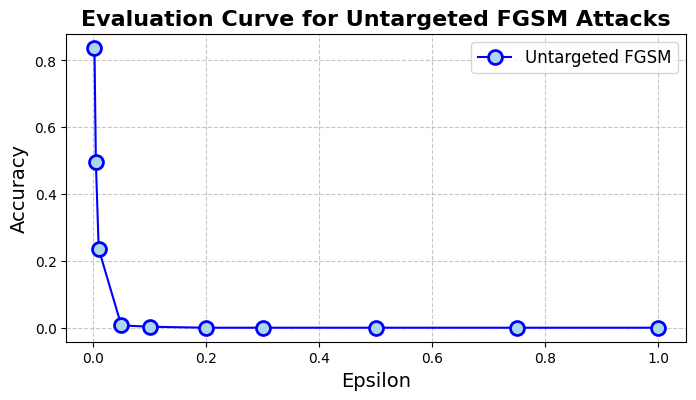

In [ ]:
accuracy_NFGSM = np.load("AccuracyNN1\\nn1_accuracy_NFGSM.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the untargeted FGSM attack
plt.plot(eps_values_NFGSM, accuracy_NFGSM, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Untargeted FGSM")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Untargeted FGSM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Epsilon vs Perturbation

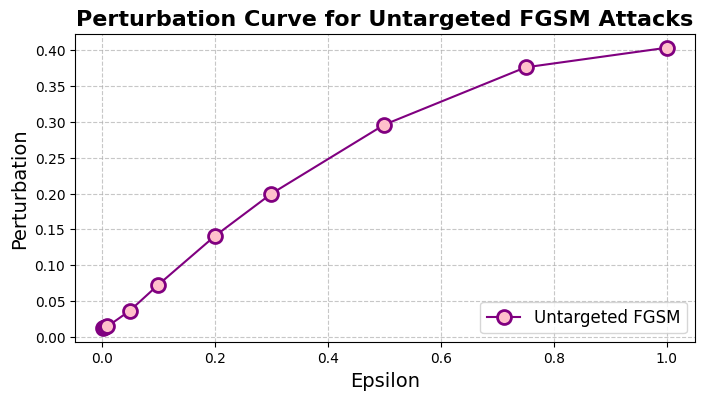

In [ ]:
perturbation_NFGSM = np.load("Perturbation\\perturbation_NFGSM.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the untargeted FGSM attack
plt.plot(eps_values_NFGSM, perturbation_NFGSM, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Untargeted FGSM")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for Untargeted FGSM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## TARGETED FGSM

Generate attack

In [ ]:
eps_values_TFGSM = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

In [ ]:
path = "1000Campioni\\"
accuracy_TFGSM = []
for epsilon in eps_values_TFGSM:
    target_class = np.where(LABELS == ' Brad_Pitt')[0]
    # Step 1: Create the attack
    attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=True)

    targeted_labels = target_class*np.ones(LABELS.size)
    one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = LABELS.size)

    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "TFGSM", "Epsilon_" + str(epsilon), p)
        os.makedirs(save_dir, exist_ok=True)

        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            image = load_image(image_path)

            # Step 2: Generate the adversarial samples
            adv = attack.generate(image.unsqueeze(0).numpy(),one_hot_targeted_labels)

            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)
            adv.save("adv\\TFGSM\\Epsilon_" + str(epsilon) + "\\" + p + "\\" + i)

Calculate accuracy and pertutbation

In [ ]:
accuracy_TFGSM, perturbation_TFGSM = evaluate_targeted_attack("adv\\TFGSM", 'Brad_Pitt')

Value:  0.0025  Accuracy:  0.0 % Perturbation:  0.01
Value:  0.005  Accuracy:  0.6 % Perturbation:  0.01
Value:  0.01  Accuracy:  3.3 % Perturbation:  0.01
Value:  0.05  Accuracy:  46.05 % Perturbation:  0.04
Value:  0.1  Accuracy:  31.37 % Perturbation:  0.07
Value:  0.2  Accuracy:  1.4 % Perturbation:  0.14
Value:  0.3  Accuracy:  0.0 % Perturbation:  0.2
Value:  0.5  Accuracy:  0.0 % Perturbation:  0.3
Value:  0.75  Accuracy:  0.0 % Perturbation:  0.38
Value:  1  Accuracy:  0.0 % Perturbation:  0.4


In [ ]:
accuracy_array = np.array(accuracy_TFGSM)
perturbation_array = np.array(perturbation_TFGSM)

np.save("AccuracyNN1\\nn1_accuracy_TFGSM.npy", accuracy_array)
np.save("Perturbation\\perturbation_TFGSM.npy", perturbation_array)

### Security Evaluation Curves for Targeted FGSM attack

Accuracy vs Epsilon

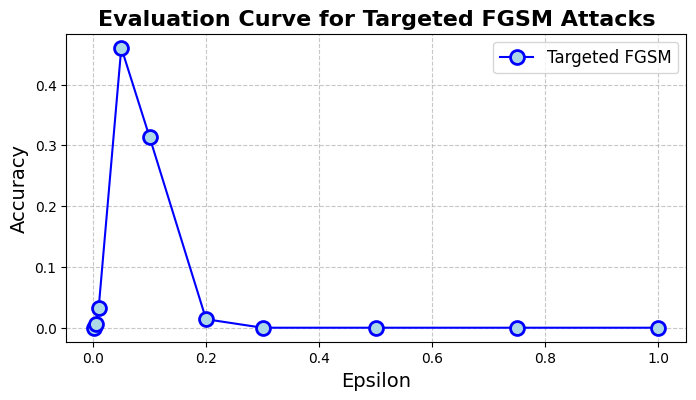

In [ ]:
accuracy_TFGSM = np.load("AccuracyNN1\\nn1_accuracy_TFGSM.npy")

plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted FGSM attack
plt.plot(eps_values_TFGSM, accuracy_TFGSM, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Targeted FGSM")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Targeted FGSM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Epsilon

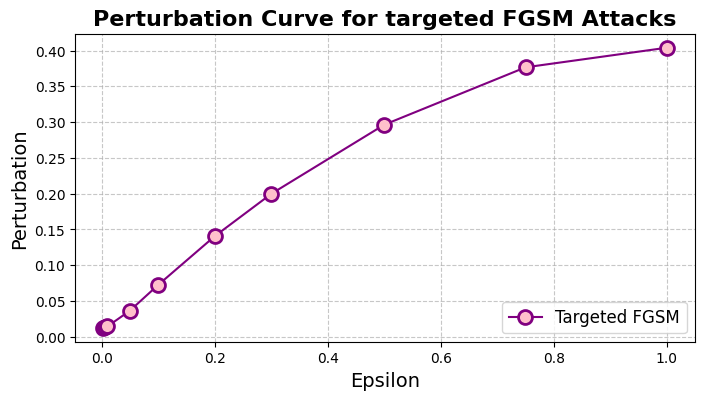

In [ ]:
perturbation_TFGSM = np.load("Perturbation\\perturbation_TFGSM.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the targeted FGSM attack
plt.plot(eps_values_TFGSM, perturbation_TFGSM, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Targeted FGSM")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for targeted FGSM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## NON TARGETED BIM

### EPSILON

In [ ]:
bim_eps_values = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

In [ ]:
from art.attacks.evasion import BasicIterativeMethod

epsilon_step = 0.05
max_iter = 20
for epsilon in bim_eps_values:
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, max_iter=max_iter, eps_step=epsilon_step)

    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "NBIM","Epsilon","Epsilon_" + str(epsilon), p)
        os.makedirs(save_dir, exist_ok=True)

        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)
            # Load the image
            image = load_image(image_path)

            # Generate the adversarial samples
            adv = attack.generate(image.unsqueeze(0).numpy())

            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\NBIM\\Epsilon\\Epsilon_" + str(epsilon) + "\\" + p + "\\" + i)


Calculate accuracy and perturbation

In [ ]:
accuracy_NBIMEp, perturbation_NBIMEp = evaluate_untargeted_attack("adv\\NBIM\\Epsilon")

Value:  0.0025  Accuracy:  83.0 % Perturbation:  0.01
Value:  0.005  Accuracy:  39.2 % Perturbation:  0.01
Value:  0.01  Accuracy:  13.5 % Perturbation:  0.01
Value:  0.05  Accuracy:  0.0 % Perturbation:  0.03
Value:  0.1  Accuracy:  0.0 % Perturbation:  0.05
Value:  0.2  Accuracy:  0.0 % Perturbation:  0.09
Value:  0.3  Accuracy:  0.0 % Perturbation:  0.11
Value:  0.5  Accuracy:  0.0 % Perturbation:  0.12
Value:  0.75  Accuracy:  0.0 % Perturbation:  0.12
Value:  1  Accuracy:  0.0 % Perturbation:  0.12


In [ ]:
accuracy_array = np.array(accuracy_NBIMEp)
perturbation_array = np.array(perturbation_NBIMEp)

np.save("AccuracyNN1\\nn1_accuracy_NBIMEp.npy", accuracy_array)
np.save("Perturbation\\perturbation_NBIMEp.npy", perturbation_array)

#### Security Evaluation Curve for Untargeted BIM Attacks

Accuracy vs Epsilon

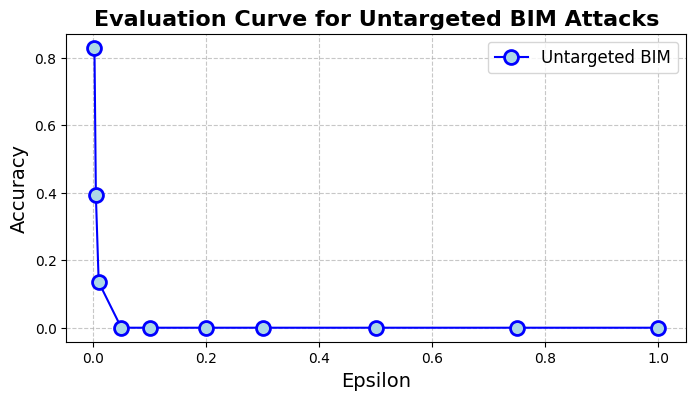

In [ ]:
accuracy_NBIMEp = np.load("AccuracyNN1\\nn1_accuracy_NBIMEp.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the untargeted BIM attack
plt.plot(bim_eps_values, accuracy_NBIMEp, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Untargeted BIM")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Untargeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Epsilon

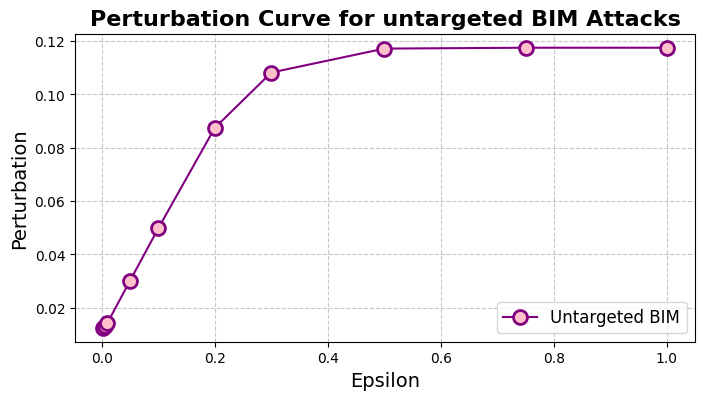

In [ ]:
perturbation_NBIMEp = np.load("Perturbation\\perturbation_NBIMEp.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the untargeted BIM attack
plt.plot(bim_eps_values, perturbation_NBIMEp, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Untargeted BIM")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for untargeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### STEP


In [ ]:
epsilon_step = [0.0005, 0.002, 0.004, 0.01, 0.02, 0.04]

In [ ]:
epsilon = 0.05
max_iter = 20
for step in epsilon_step:
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, max_iter=max_iter, eps_step=step)
    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "NBIM","Step", "Step_" + str(step), p)
        os.makedirs(save_dir, exist_ok=True)

        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            image = load_image(image_path)

            # Step 2: Generate the adversarial samples
            adv = attack.generate(image.unsqueeze(0).numpy())

            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\NBIM\\Step\\Step_" + str(step) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_NBIMStep, perturbation_NBIMStep = evaluate_untargeted_attack("adv\\NBIM\\Step")

Value:  0.0005  Accuracy:  39.26 % Perturbation:  0.01
Value:  0.002  Accuracy:  0.3 % Perturbation:  0.02
Value:  0.004  Accuracy:  0.0 % Perturbation:  0.02
Value:  0.01  Accuracy:  0.0 % Perturbation:  0.03
Value:  0.02  Accuracy:  0.0 % Perturbation:  0.03
Value:  0.04  Accuracy:  0.0 % Perturbation:  0.03


In [ ]:
accuracy_array = np.array(accuracy_NBIMStep)
perturbation_array = np.array(perturbation_NBIMStep)

np.save("AccuracyNN1\\nn1_accuracy_NBIMStep.npy", accuracy_array)
np.save("Perturbation\\perturbation_NBIMStep.npy", perturbation_array)

#### Security Evaluation Curve for Untargeted BIM Attacks

Accuracy vs Epsilon_Step

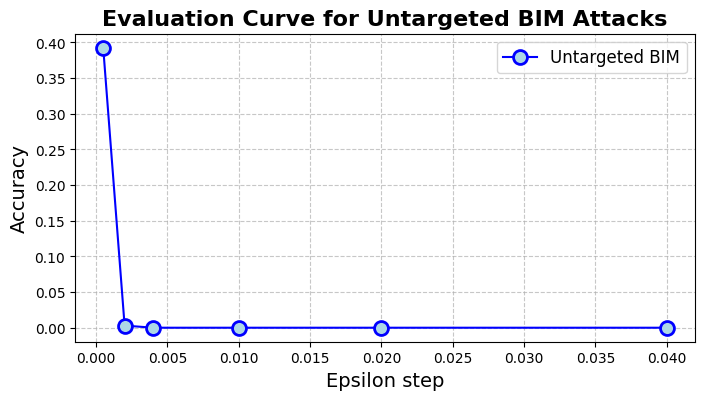

In [ ]:
accuracy_NBIMStep = np.load("AccuracyNN1\\nn1_accuracy_NBIMStep.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted BIM attack
plt.plot(epsilon_step, accuracy_NBIMStep, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Untargeted BIM")

# Visualization settings
plt.xlabel('Epsilon step', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Untargeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Epsilon_Step

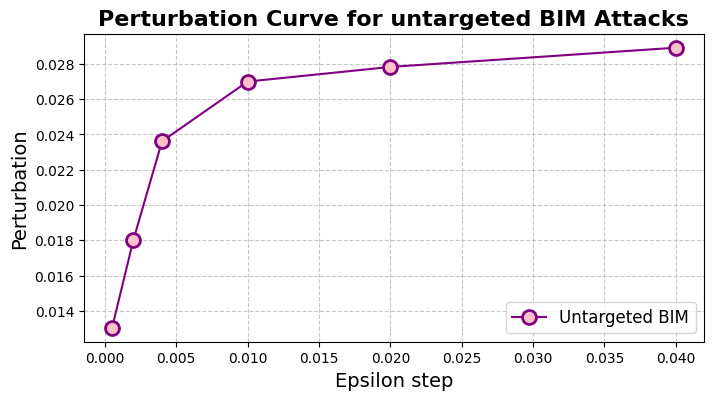

In [ ]:
perturbation_NBIMStep = np.load("Perturbation\\perturbation_NBIMStep.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the untargeted BIM attack
plt.plot(epsilon_step, perturbation_NBIMStep, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Untargeted BIM")

# Visualization settings
plt.xlabel('Epsilon step', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for untargeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Maxiter

In [ ]:
max_iter = [0, 1, 2, 5, 10, 15, 20, 50]

In [ ]:
epsilon = 0.05
epsilon_step = 0.04
for iter in max_iter:
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, max_iter=iter, eps_step=epsilon_step)

    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "NBIM","Iter", "Iter_" + str(iter), p)
        os.makedirs(save_dir, exist_ok=True)
        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            image = load_image(image_path)

            #Generate the adversarial samples
            adv = attack.generate(image.unsqueeze(0).numpy())


            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\NBIM\\Iter\\Iter_" + str(iter) + "\\" + p + "\\" + i)


Calculate accuracy and perturbation

In [ ]:
accuracy_NBIMMi, perturbation_NBIMMi = evaluate_untargeted_attack("adv\\NBIM\\Iter")

Value:  0  Accuracy:  92.71 % Perturbation:  0.01
Value:  1  Accuracy:  0.7 % Perturbation:  0.04
Value:  2  Accuracy:  0.1 % Perturbation:  0.03
Value:  5  Accuracy:  0.0 % Perturbation:  0.03
Value:  10  Accuracy:  0.2 % Perturbation:  0.03
Value:  15  Accuracy:  0.0 % Perturbation:  0.03
Value:  20  Accuracy:  0.0 % Perturbation:  0.03
Value:  50  Accuracy:  0.0 % Perturbation:  0.03


In [ ]:
accuracy_array = np.array(accuracy_NBIMMi)
perturbation_array = np.array(perturbation_NBIMMi)

np.save("AccuracyNN1\\nn1_accuracy_NBIMMi.npy", accuracy_array)
np.save("Perturbation\\perturbation_NBIMMi.npy", perturbation_array)

#### Security Evaluation Curve for Untargeted BIM Attacks

Accuracy vs Max_Iter

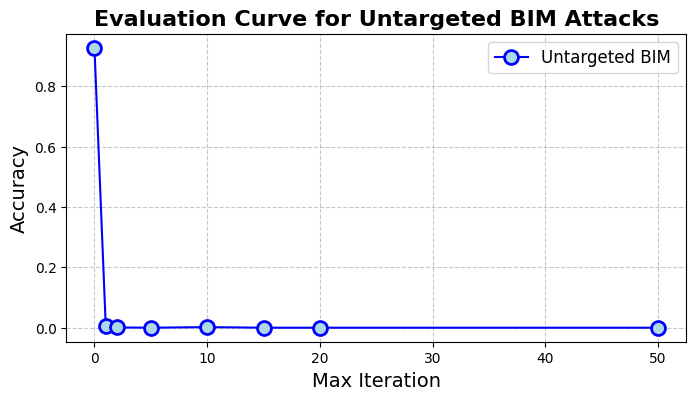

In [ ]:
accuracy_NBIMMi = np.load("AccuracyNN1\\nn1_accuracy_NBIMMi.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the untargeted BIM attack
plt.plot(max_iter, accuracy_NBIMMi, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Untargeted BIM")

# Visualization settings
plt.xlabel('Max Iteration', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Untargeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Max_Iter

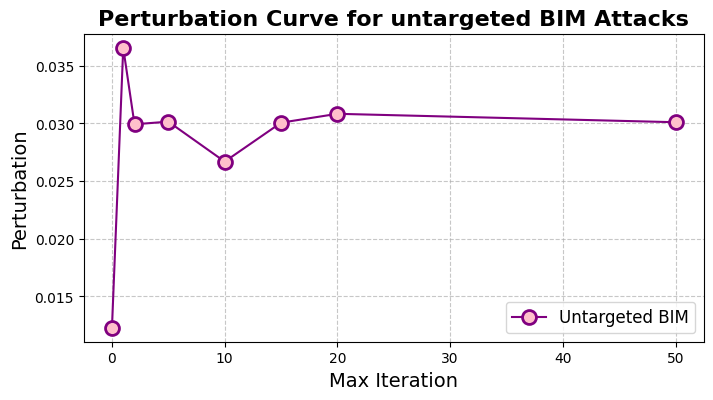

In [ ]:
perturbation_NBIMMi = np.load("Perturbation\\perturbation_NBIMMi.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the untargeted BIM attack
plt.plot(max_iter, perturbation_NBIMMi, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Untargeted BIM")

# Visualization settings
plt.xlabel('Max Iteration', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for untargeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## TARGETED BIM

### Epsilon

In [ ]:
bim_eps_values = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

In [ ]:
from art.attacks.evasion import BasicIterativeMethod

epsilon_step = 0.05
max_iter = 20

target_class = np.where(LABELS == ' Brad_Pitt')[0]
targeted_labels = target_class*np.ones(1)
one_hot_targeted_labels = tf.one_hot(targeted_labels, LABELS.size)

for epsilon in bim_eps_values:
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon,eps_step=epsilon_step, max_iter=max_iter, targeted=True)

    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "TBIM","Epsilon" "Epsilon_" + str(epsilon), p)
        os.makedirs(save_dir, exist_ok=True)
        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            image = load_image(image_path)

            # Step 2: Generate the adversarial samples
            adv = attack.generate(image.unsqueeze(0).numpy(),one_hot_targeted_labels.numpy())



            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\TBIM\\Epsilon\\Epsilon_" + str(epsilon) + "\\" + p + "\\" + i)



Calculate accuracy and perturbation

In [ ]:
accuracy_TBIMEp, perturbation_TBIMEp = evaluate_untargeted_attack("adv\\TBIM\\Epsilon", 'Brad_Pitt')

Epsilon:  0.0025  Accuracy:  0.0 % Perturbation:  0.01
Epsilon:  0.005  Accuracy:  0.3 % Perturbation:  0.01
Epsilon:  0.01  Accuracy:  0.4 % Perturbation:  0.01
Epsilon:  0.05  Accuracy:  72.8 % Perturbation:  0.03
Epsilon:  0.1  Accuracy:  99.4 % Perturbation:  0.05
Epsilon:  0.2  Accuracy:  100.0 % Perturbation:  0.09
Epsilon:  0.3  Accuracy:  100.0 % Perturbation:  0.11
Epsilon:  0.5  Accuracy:  100.0 % Perturbation:  0.13
Epsilon:  0.75  Accuracy:  100.0 % Perturbation:  0.13
Epsilon:  1  Accuracy:  100.0 % Perturbation:  0.13


In [ ]:
accuracy_array = np.array(accuracy_TBIMEp)
perturbation_array = np.array(perturbation_TBIMEp)

np.save("AccuracyNN1\\nn1_accuracy_TBIMEp.npy", accuracy_array)
np.save("Perturbation\\perturbation_TBIMEp.npy", perturbation_array)

#### Security Evaluation Curve for Targeted BIM Attacks

Accuracy vs Epsilon

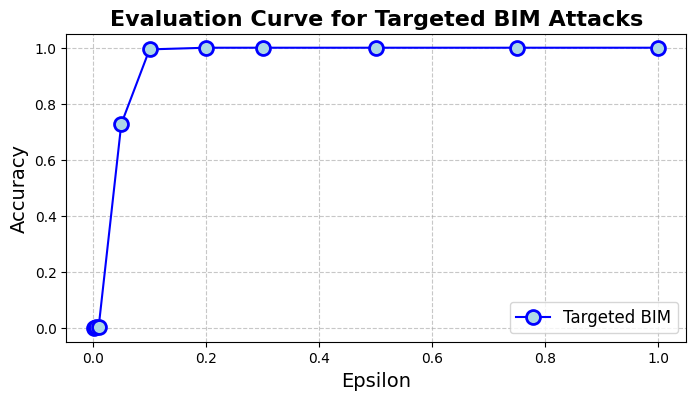

In [ ]:
accuracy_TBIMEp = np.load("AccuracyNN1\\nn1_accuracy_TBIMEp.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted BIM attack
plt.plot(bim_eps_values, accuracy_TBIMEp, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Targeted BIM")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Targeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Epsilon

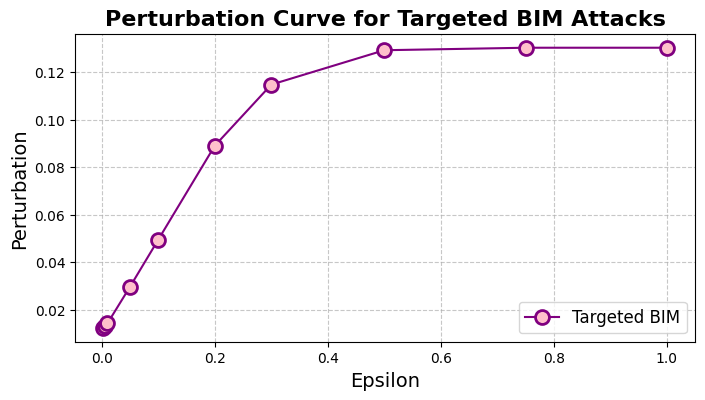

In [ ]:
perturbation_TBIMEp = np.load("Perturbation\\perturbation_TBIMEp.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the untargeted BIM attack
plt.plot(bim_eps_values, perturbation_TBIMEp, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Targeted BIM")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for Targeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Step


In [ ]:
epsilon_step = [ 0.0005, 0.002, 0.004, 0.01, 0.02, 0.04]

In [ ]:
epsilon = 0.1
max_iter = 20

target_class = np.where(LABELS == ' Brad_Pitt')[0]
targeted_labels = target_class*np.ones(1)
one_hot_targeted_labels = tf.one_hot(targeted_labels, LABELS.size)

for step in epsilon_step:
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon,eps_step=step, max_iter=max_iter, targeted=True)

    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "TBIM","Step", "Step_" + str(step), p)
        os.makedirs(save_dir, exist_ok=True)
        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            image = load_image(image_path)

            # Step 2: Generate the adversarial samples
            adv = attack.generate(image.unsqueeze(0).numpy(),one_hot_targeted_labels.numpy())



            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\TBIM\\Step\\Step_" + str(step) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_TBIMStep, perturbation_TBIMStep = evaluate_targeted_attack("adv\\TBIM\\Step", 'Brad_Pitt')

Value:  0.0005  Accuracy:  0.8 % Perturbation:  0.01
Value:  0.002  Accuracy:  93.71 % Perturbation:  0.02
Value:  0.004  Accuracy:  100.0 % Perturbation:  0.02
Value:  0.01  Accuracy:  100.0 % Perturbation:  0.03
Value:  0.02  Accuracy:  99.8 % Perturbation:  0.03
Value:  0.04  Accuracy:  86.81 % Perturbation:  0.03


In [ ]:
accuracy_array = np.array(accuracy_TBIMStep)
perturbation_array = np.array(perturbation_TBIMStep)

np.save("AccuracyNN1\\nn1_accuracy_TBIMStep.npy", accuracy_array)
np.save("Perturbation\\perturbation_TBIMStep.npy", perturbation_array)

#### Security Evaluation Curve for Targeted BIM Attacks

Accuracy vs Epsilon_Step

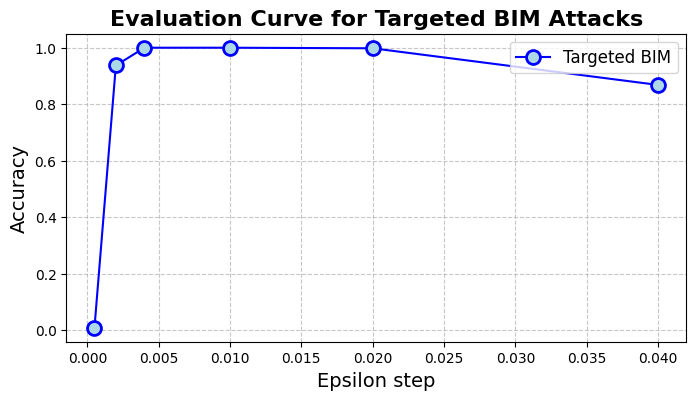

In [ ]:
accuracy_TBIMStep = np.load("AccuracyNN1\\nn1_accuracy_TBIMStep.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted BIM attack
plt.plot(epsilon_step, accuracy_TBIMStep, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Targeted BIM")

# Visualization settings
plt.xlabel('Epsilon step', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Targeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Epsilon_Step

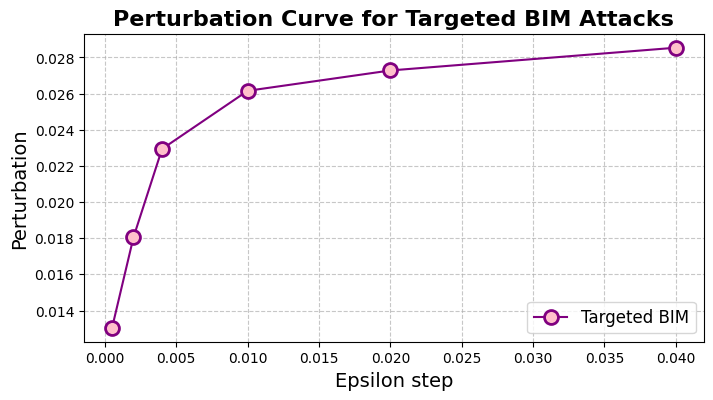

In [ ]:
perturbation_TBIMStep = np.load("Perturbation\\perturbation_TBIMStep.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the targeted BIM attack
plt.plot(epsilon_step, perturbation_TBIMStep, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Targeted BIM")

# Visualization settings
plt.xlabel('Epsilon step', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for Targeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Max Iter


In [ ]:
max_iter = [0, 1, 2, 5, 10, 15, 20, 50]

In [ ]:
epsilon = 0.1
epsilon_step = 0.04
accuracy_TBIM_I = []


target_class = np.where(LABELS == ' Brad_Pitt')[0]
targeted_labels = target_class*np.ones(1)
one_hot_targeted_labels = tf.one_hot(targeted_labels, LABELS.size)

for iter in max_iter:
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon,eps_step=step, max_iter=iter, targeted=True)
    total = 0
    correct_predictions = 0
    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "TBIM","Iter", "Iter" + str(iter), p)
        os.makedirs(save_dir, exist_ok=True)
        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            image = load_image(image_path)

            # Step 2: Generate the adversarial samples
            adv = attack.generate(image.unsqueeze(0).numpy(),one_hot_targeted_labels.numpy())

            pred = classifier.predict(torch.tensor(adv))



            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\TBIM\\Iter\\Iter_" + str(step) + "\\" + p + "\\" + i)


Calculate accuracy and perturbation

In [ ]:
accuracy_TBIMMi, perturbation_TBIMMi = evaluate_targeted_attack("adv\\TBIM\\Iter", 'Brad_Pitt')

Value:  0  Accuracy:  0.0 % Perturbation:  0.01
Value:  1  Accuracy:  46.05 % Perturbation:  0.04
Value:  2  Accuracy:  69.93 % Perturbation:  0.03
Value:  5  Accuracy:  74.73 % Perturbation:  0.03
Value:  10  Accuracy:  82.82 % Perturbation:  0.03
Value:  15  Accuracy:  91.23 % Perturbation:  0.03
Value:  20  Accuracy:  100.0 % Perturbation:  0.03
Value:  50  Accuracy:  100.0 % Perturbation:  0.03


In [ ]:
accuracy_array = np.array(accuracy_TBIMMi)
perturbation_array = np.array(perturbation_TBIMMi)

np.save("AccuracyNN1\\nn1_accuracy_TBIMMi.npy", accuracy_array)
np.save("Perturbation\\perturbation_TBIMMi.npy", perturbation_array)

#### Security Evaluation Curve for Targeted BIM Attacks

Accuracy vs Max_Iter

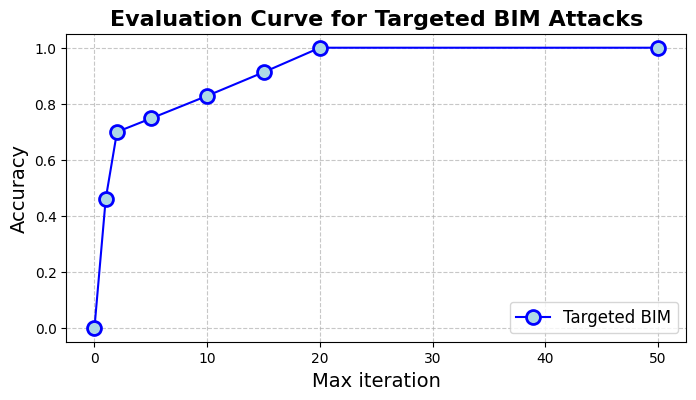

In [ ]:
accuracy_TBIMMi = np.load("AccuracyNN1\\nn1_accuracy_TBIMMi.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted BIM attack
plt.plot(max_iter, accuracy_TBIMMi, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Targeted BIM")

# Visualization settings
plt.xlabel('Max iteration', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Targeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturturbation vs Max_Iter

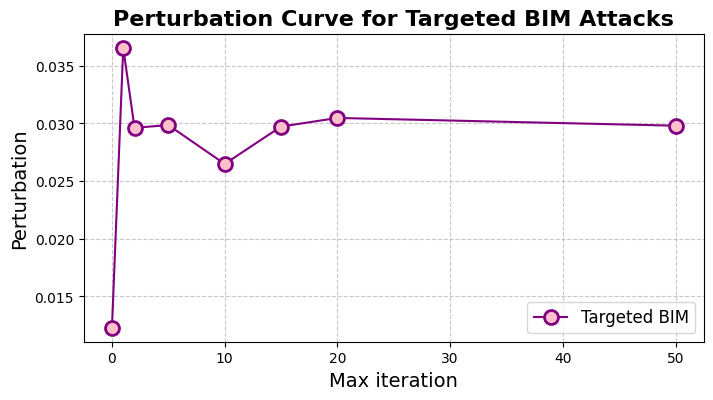

In [ ]:
perturbation_TBIMMi = np.load("Perturbation\\perturbation_TBIMMi.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the targeted BIM attack
plt.plot(max_iter, perturbation_TBIMMi, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Targeted BIM")

# Visualization settings
plt.xlabel('Max iteration', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for Targeted BIM Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## NON TARGETED CARLINI & WAGNER

Generate Attack

In [ ]:
confidence_list = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

In [ ]:
from art.attacks.evasion import CarliniL2Method
# Preporocessing
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])
# Carlini parameters
binary_search_steps = 10
max_iter = 7
learning_rate = 0.05
initial_const = 0.01

for confidence in confidence_list:
    attack = CarliniL2Method(classifier=classifier, confidence=confidence,learning_rate=learning_rate, max_iter=max_iter, initial_const=initial_const, binary_search_steps=binary_search_steps,targeted=False)

    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "NCL2", "Confidence_" + str(confidence), p)
        os.makedirs(save_dir, exist_ok=True)
        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)
            print(image_path)
            # Load the image
            image = Image.open(image_path)
            input_image = preprocess(image).unsqueeze(0)

            # Generate the adversarial samples
            adv = attack.generate(input_image.numpy())

            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\NCL2\\Confidence_" + str(confidence) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_NCW, perturbation_NCW = evaluate_untargeted_attack("adv\\NCL2")

Value:  0.0025  Accuracy:  36.0 % Perturbation:  0.01
Value:  0.005  Accuracy:  35.5 % Perturbation:  0.01
Value:  0.01  Accuracy:  35.5 % Perturbation:  0.01
Value:  0.05  Accuracy:  29.5 % Perturbation:  0.01
Value:  0.1  Accuracy:  0.0 % Perturbation:  0.01
Value:  0.2  Accuracy:  0.0 % Perturbation:  0.01
Value:  0.3  Accuracy:  0.0 % Perturbation:  0.01
Value:  0.5  Accuracy:  0.0 % Perturbation:  0.01
Value:  0.75  Accuracy:  0.0 % Perturbation:  0.01
Value:  1  Accuracy:  0.0 % Perturbation:  0.01


In [ ]:
accuracy_array = np.array(accuracy_NCW)
perturbation_array = np.array(perturbation_NCW)

np.save("AccuracyNN1\\nn1_accuracy_NCW.npy", accuracy_array)
np.save("Perturbation\\perturbation_NCW.npy", perturbation_array)

#### Security Evaluation Curve for Untargeted Carlini Wagner Attacks

Accuracy vs Confidence

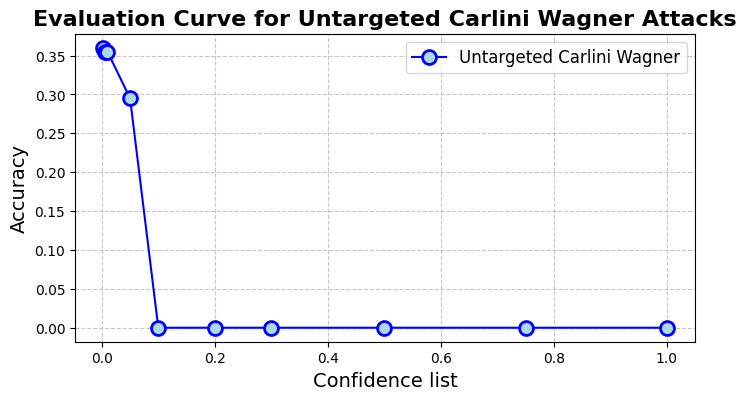

In [ ]:
accuracy_NCW = np.load("AccuracyNN1\\nn1_accuracy_NCW.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted CW attack
plt.plot(confidence_list, accuracy_NCW, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Untargeted Carlini Wagner")

# Visualization settings
plt.xlabel('Confidence list', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Untargeted Carlini Wagner Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Confidence

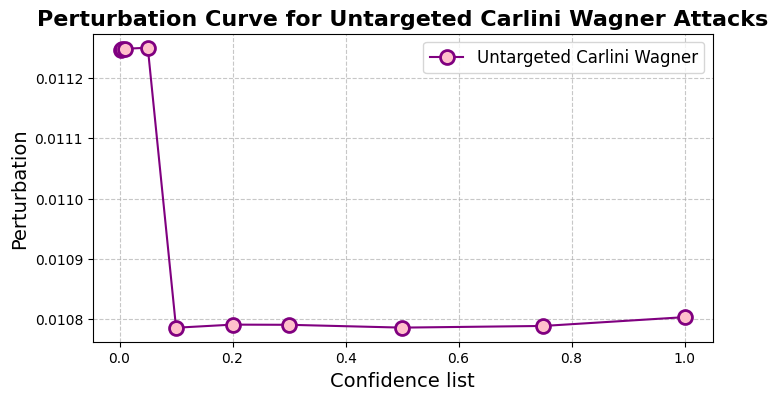

In [ ]:
perturbation_NCW = np.load("Perturbation\\perturbation_NCW.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the untargeted Confidence list attack
plt.plot(confidence_list, perturbation_NCW, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Untargeted Carlini Wagner")

# Visualization settings
plt.xlabel('Confidence list', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for Untargeted Carlini Wagner Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## TARGETED CARLINI & WAGNER

Generate attack

In [ ]:
confidence_list = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

In [ ]:
from art.attacks.evasion import CarliniL2Method
# Preporocessing
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])
# Carlini parameters
binary_search_steps = 10
max_iter = 7
learning_rate = 0.05
initial_const = 0.01

#Target parameters
target_class = np.where(LABELS == ' Brad_Pitt')[0]
targeted_labels = target_class * np.ones(input_image.shape[0], dtype=np.int64)
one_hot_targeted_labels = tf.one_hot(targeted_labels, LABELS.size)

for confidence in confidence_list:
    attack = CarliniL2Method(classifier=classifier, confidence=confidence,learning_rate=learning_rate, max_iter=max_iter, initial_const=initial_const, binary_search_steps=binary_search_steps,targeted=True)

    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "TCL2", "Confidence_" + str(confidence), p)
        os.makedirs(save_dir, exist_ok=True)
        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)
            print(image_path)
            # Load the image
            image = Image.open(image_path)
            input_image = preprocess(image).unsqueeze(0)

            # Generate the adversarial samples
            adv = attack.generate(input_image.numpy(), y=one_hot_targeted_labels)

            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\TCL2\\Confidence_" + str(confidence) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_TCW, perturbation_TCW = evaluate_targeted_attack("adv\\TCL2", 'Brad_Pitt')

Value:  0.0025  Accuracy:  1.0 % Perturbation:  0.0
Value:  0.005  Accuracy:  37.0 % Perturbation:  0.01
Value:  0.01  Accuracy:  39.0 % Perturbation:  0.01
Value:  0.05  Accuracy:  36.0 % Perturbation:  0.01
Value:  0.1  Accuracy:  38.0 % Perturbation:  0.01
Value:  0.2  Accuracy:  40.0 % Perturbation:  0.01
Value:  0.3  Accuracy:  45.0 % Perturbation:  0.01
Value:  0.5  Accuracy:  58.0 % Perturbation:  0.01
Value:  0.75  Accuracy:  77.0 % Perturbation:  0.01
Value:  1  Accuracy:  85.0 % Perturbation:  0.01


In [ ]:
accuracy_array = np.array(accuracy_TCW)
perturbation_array = np.array(perturbation_TCW)

np.save("AccuracyNN1\\nn1_accuracy_TCW.npy", accuracy_array)
np.save("Perturbation\\perturbation_TCW.npy", perturbation_array)

#### Security Evaluation Curve for Targeted Carlini Wagner Attacks

Accuracy vs Confidence

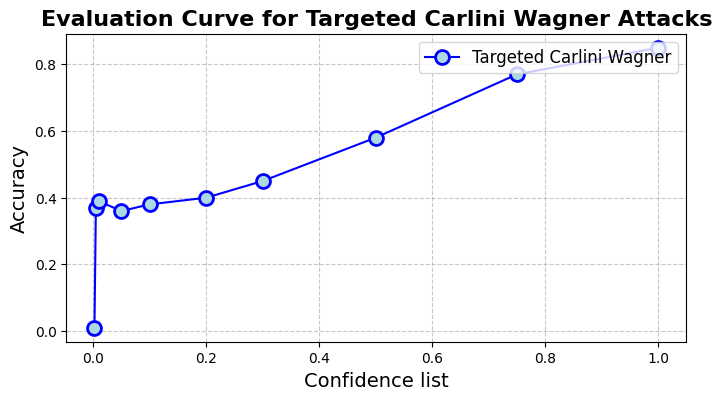

In [ ]:
accuracy_TCW = np.load("AccuracyNN1\\nn1_accuracy_TCW.npy")

plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted CW attack
plt.plot(confidence_list, accuracy_TCW, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Targeted Carlini Wagner")

# Visualization settings
plt.xlabel('Confidence list', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Targeted Carlini Wagner Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Confidence

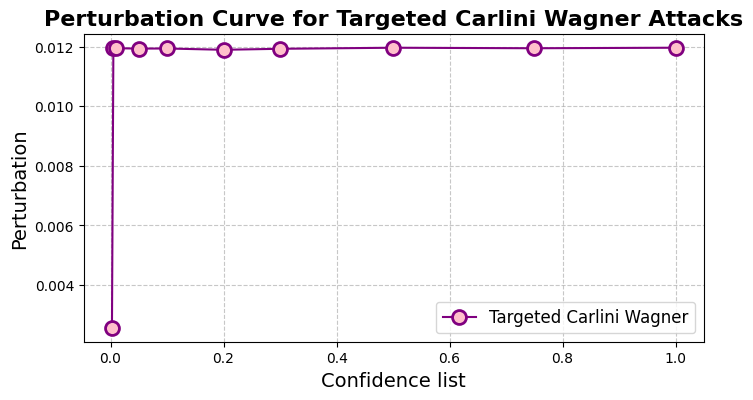

In [ ]:
perturbation_TCW = np.load("Perturbation\\perturbation_TCW.npy")

plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the targeted CW attack
plt.plot(confidence_list, perturbation_TCW, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Targeted Carlini Wagner")

# Visualization settings
plt.xlabel('Confidence list', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for Targeted Carlini Wagner Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## DEEPFOOL

Generate attack

In [ ]:
eps_values_NDF = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

In [ ]:
from art.attacks.evasion import DeepFool

# Preporocessing
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])
# DeepFool parameters

max_iter = 15

for epsilon in eps_values_NDF:
    attack = DeepFool(classifier=classifier, max_iter=max_iter, epsilon=epsilon)

    for p in os.listdir(path):
        dir = os.path.join(path, p)

        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "NDF", "Epsilon_" + str(epsilon), p)
        os.makedirs(save_dir, exist_ok=True)

        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)
            print(image_path)
            # Load the image
            image = Image.open(image_path)
            input_image = preprocess(image).unsqueeze(0)

            # Generate the adversarial samples
            adv = attack.generate(input_image.numpy())



            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\NDF\\Epsilon_" + str(epsilon) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_NDFEp, perturbation_NDFEp = evaluate_untargeted_attack("adv\\NDF")

Value:  0.0025  Accuracy:  8.0 % Perturbation:  0.01
Value:  0.005  Accuracy:  7.5 % Perturbation:  0.01
Value:  0.01  Accuracy:  7.1 % Perturbation:  0.01
Value:  0.05  Accuracy:  4.6 % Perturbation:  0.01
Value:  0.1  Accuracy:  2.5 % Perturbation:  0.01
Value:  0.2  Accuracy:  1.4 % Perturbation:  0.01
Value:  0.3  Accuracy:  1.3 % Perturbation:  0.01
Value:  0.5  Accuracy:  1.2 % Perturbation:  0.01
Value:  0.75  Accuracy:  1.1 % Perturbation:  0.01
Value:  1  Accuracy:  1.1 % Perturbation:  0.01


In [ ]:
accuracy_array = np.array(accuracy_NDFEp)
perturbation_array = np.array(perturbation_NDFEp)

np.save("AccuracyNN1\\nn1_accuracy_NDFEp.npy", accuracy_array)
np.save("Perturbation\\perturbation_NDFEp.npy", perturbation_array)

#### Security Evaluation Curve for Non Targeted DeepFool Attacks

Accuracy vs Epsilon

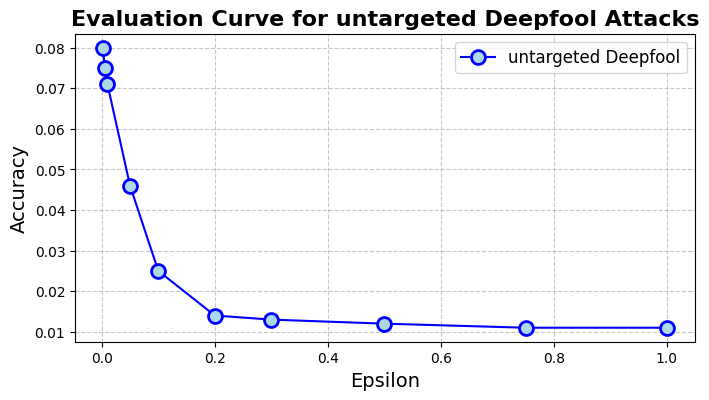

In [ ]:
accuracy_NDFEp = np.load("AccuracyNN1\\nn1_accuracy_NDFEp.npy")

plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted DF attack
plt.plot(eps_values_NDF, accuracy_NDFEp, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="untargeted Deepfool")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for untargeted Deepfool Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Epsilon

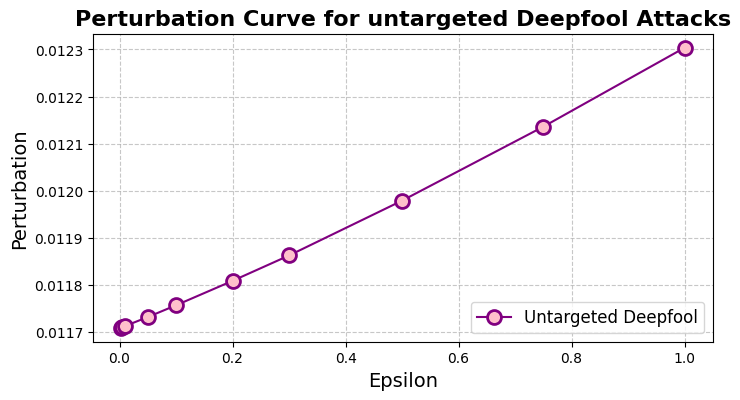

In [ ]:
perturbation_NDFEp = np.load("Perturbation\\perturbation_NDFEp.npy")

plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the targeted DF attack
plt.plot(eps_values_NDF, perturbation_NDFEp, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Untargeted Deepfool")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for untargeted Deepfool Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## NON TARGETED PGD

Generate attack

### Epsilon


In [ ]:
epsilon_list = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

# Preporocessing
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

# PGD parameters

epsilon_step = 0.05
max_iter = 20
num_random_init = 5

for epsilon in epsilon_list:
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, num_random_init=num_random_init)

    for p in os.listdir(path):
        dir = os.path.join(path, p)

        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "NPGD", "Epsilon", "Epsilon_" + str(epsilon), p)
        os.makedirs(save_dir, exist_ok=True)

        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            image = Image.open(image_path)
            input_image = preprocess(image).unsqueeze(0)

            # Generate the adversarial samples
            adv = attack.generate(input_image.numpy())

            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\NPGD\\Epsilon\\Epsilon_" + str(epsilon) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_NPGDEp, perturbation_NPGDEp = evaluate_untargeted_attack("adv\\NPGD\\Epsilon")

Value:  0.0025  Accuracy:  80.5 % Perturbation:  0.01
Value:  0.005  Accuracy:  33.0 % Perturbation:  0.01
Value:  0.01  Accuracy:  10.0 % Perturbation:  0.01
Value:  0.05  Accuracy:  0.0 % Perturbation:  0.03
Value:  0.1  Accuracy:  0.0 % Perturbation:  0.05
Value:  0.2  Accuracy:  0.0 % Perturbation:  0.09
Value:  0.3  Accuracy:  0.0 % Perturbation:  0.12
Value:  0.5  Accuracy:  0.0 % Perturbation:  0.17
Value:  0.75  Accuracy:  0.0 % Perturbation:  0.21
Value:  1  Accuracy:  0.0 % Perturbation:  0.25


In [ ]:
accuracy_array = np.array(accuracy_NPGDEp)
perturbation_array = np.array(perturbation_NPGDEp)

np.save("AccuracyNN1\\nn1_accuracy_NPGDEp.npy", accuracy_array)
np.save("Perturbation\\perturbation_NPGDEp.npy", perturbation_array)

#### Security Evaluation Curve for Untargeted PGD Attacks

Accuracy vs Epsilon

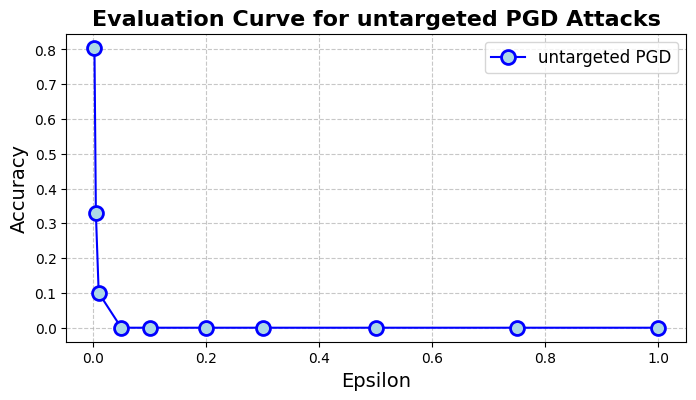

In [ ]:
accuracy_NPGDEp = np.load("AccuracyNN1\\nn1_accuracy_NPGDEp.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the untargeted PGD attack
plt.plot(epsilon_list, accuracy_NPGDEp, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="untargeted PGD")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for untargeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Epsilon_Step

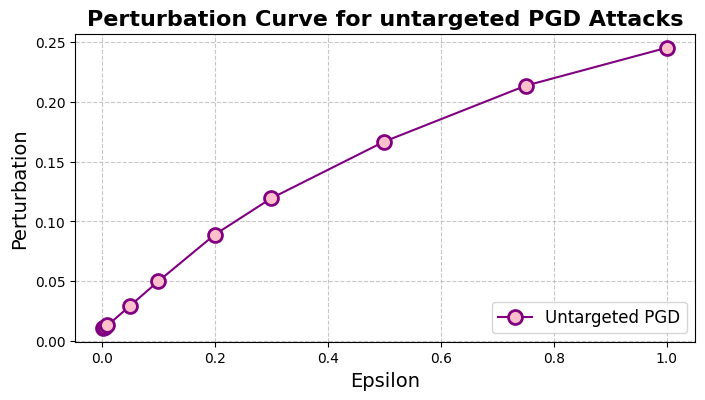

In [ ]:
perturbation_NPGDEp = np.load("Perturbation\\perturbation_NPGDEp.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the untargeted PGD attack
plt.plot(epsilon_list, perturbation_NPGDEp, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Untargeted PGD")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for untargeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Epsilon Step

In [ ]:
epsilon_step_list = [0.0005, 0.004, 0.01, 0.02, 0.04]

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

# Preporocessing
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

# PGD parameters

epsilon = 0.05
max_iter = 20
num_random_init = 5

for epsilon_step in epsilon_step_list:
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, num_random_init=num_random_init)

    for p in os.listdir(path):
        dir = os.path.join(path, p)

        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "NPGD", "Step", "Step_" + str(epsilon), p)
        os.makedirs(save_dir, exist_ok=True)

        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            image = Image.open(image_path)
            input_image = preprocess(image).unsqueeze(0)

            # Generate the adversarial samples
            adv = attack.generate(input_image.numpy())

            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\NPGD\\Step\\Step_" + str(epsilon) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_NPGDStep, perturbation_NPGDStep = evaluate_untargeted_attack("adv\\NPGD\\Step")

Value:  0.0005  Accuracy:  39.26 % Perturbation:  0.01
Value:  0.004  Accuracy:  0.3 % Perturbation:  0.01
Value:  0.01  Accuracy:  0.0 % Perturbation:  0.01
Value:  0.02  Accuracy:  0.0 % Perturbation:  0.01
Value:  0.04  Accuracy:  0.0 % Perturbation:  0.01


In [ ]:
accuracy_array = np.array(accuracy_NPGDStep)
perturbation_array = np.array(perturbation_NPGDStep)

np.save("AccuracyNN1\\nn1_accuracy_NPGDStep.npy", accuracy_array)
np.save("Perturbation\\perturbation_NPGDStep.npy", perturbation_array)

#### Security Evaluation Curve for Untargeted PGD Attacks

Accuracy vs Epsilon_Step

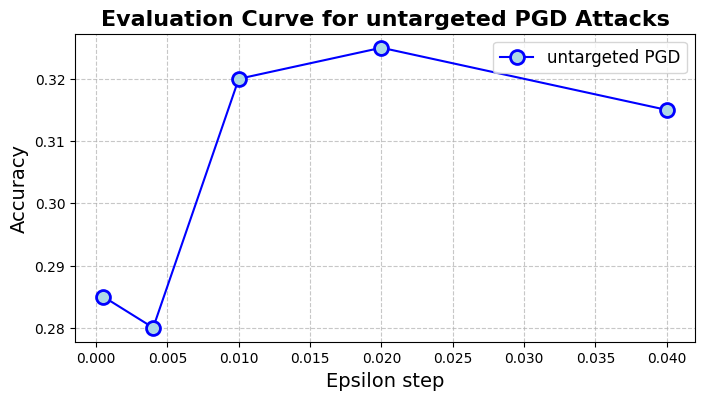

In [ ]:
accuracy_NPGDStep = np.load("AccuracyNN1\\nn1_accuracy_NPGDStep.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the untargeted PGD attack
plt.plot(epsilon_step_list, accuracy_NPGDStep, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="untargeted PGD")

# Visualization settings
plt.xlabel('Epsilon step', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for untargeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Epsilon_Step

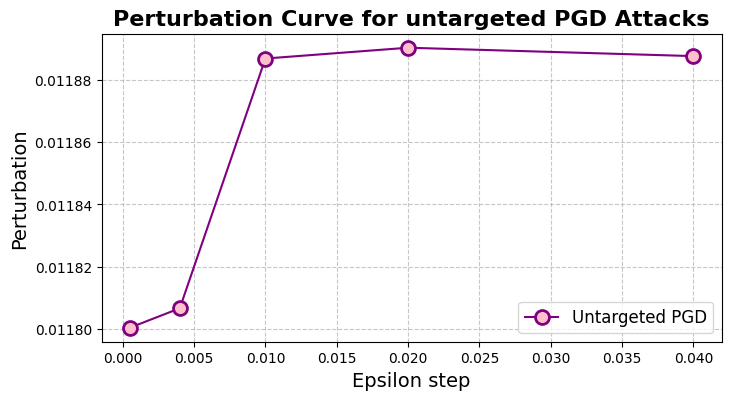

In [ ]:
perturbation_NPGDStep = np.load("Perturbation\\perturbation_NPGDStep.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the untargeted PGD attack
plt.plot(epsilon_step_list, perturbation_NPGDStep, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Untargeted PGD")

# Visualization settings
plt.xlabel('Epsilon step', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for untargeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Max Iter

In [ ]:
max_iter = [0, 1, 2, 5, 10, 15, 20, 50]

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

epsilon = 0.05
epsilon_step = 0.04
num_random_init = 5
for iter in max_iter:
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=iter, num_random_init=num_random_init)
    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "NPGD","Iter", "Iter_" + str(iter), p)
        os.makedirs(save_dir, exist_ok=True)
        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            image = load_image(image_path)

            # Step 2: Generate the adversarial samples
            adv = attack.generate(image.unsqueeze(0).numpy())


            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\NPGD\\Iter\\Iter_" + str(iter) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_NPGDMi, perturbation_NPGDMi = evaluate_untargeted_attack("adv\\NPGD\\Iter")

Value:  0  Accuracy:  91.0 % Perturbation:  0.01
Value:  1  Accuracy:  1.0 % Perturbation:  0.03
Value:  2  Accuracy:  0.0 % Perturbation:  0.03
Value:  5  Accuracy:  0.0 % Perturbation:  0.03
Value:  10  Accuracy:  0.0 % Perturbation:  0.03
Value:  15  Accuracy:  0.0 % Perturbation:  0.03
Value:  20  Accuracy:  0.0 % Perturbation:  0.03
Value:  50  Accuracy:  0.0 % Perturbation:  0.03


In [ ]:
accuracy_array = np.array(accuracy_NPGDMi)
perturbation_array = np.array(perturbation_NPGDMi)

np.save("AccuracyNN1\\nn1_accuracy_NPGDMi.npy", accuracy_array)
np.save("Perturbation\\perturbation_NPGDMi.npy", perturbation_array)

#### Security Evaluation Curve for Untargeted PGD

Accuracy vs Max_Iter

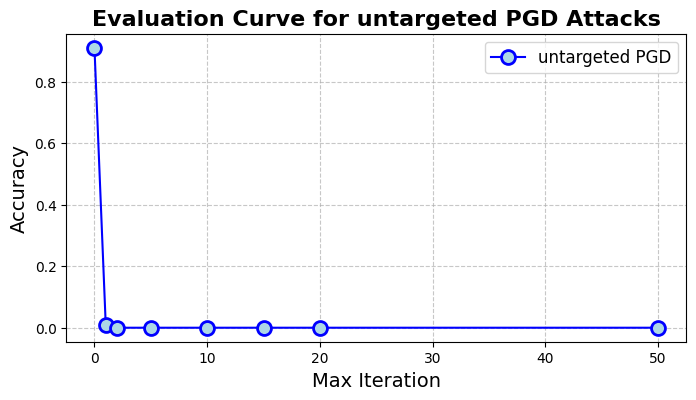

In [ ]:
accuracy_NPGDMi = np.load("AccuracyNN1\\nn1_accuracy_NPGDMi.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the untargeted PGD attack
plt.plot(max_iter, accuracy_NPGDMi, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="untargeted PGD")

# Visualization settings
plt.xlabel('Max Iteration', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for untargeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Max_Iter

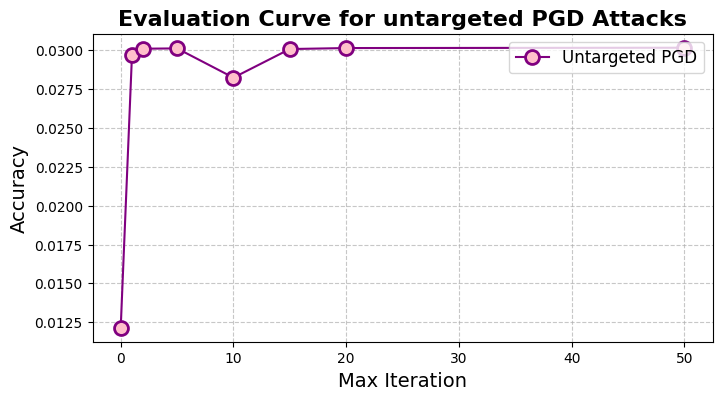

In [ ]:
perturbation_NPGDMi = np.load("Perturbation\\perturbation_NPGDMi.npy")
plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the untargeted PGD attack
plt.plot(max_iter, perturbation_NPGDMi, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Untargeted PGD")

# Visualization settings
plt.xlabel('Max Iteration', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for untargeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Num random int

In [ ]:
num_random_init = [1,3,5,7,10,15,20]

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

epsilon = 0.05
epsilon_step = 0.04
max_iter = 10

for num in num_random_init:
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, num_random_init=num)
    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "NPGD", "Num" ,"Num_random_init_" + str(num), p)
        os.makedirs(save_dir, exist_ok=True)
        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            image = load_image(image_path)

            # Step 2: Generate the adversarial samples
            adv = attack.generate(image.unsqueeze(0).numpy())


            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\NPGD\\Num\\Num_random_init_" + str(num) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_NPGDNRI, perturbation_NPGDNRI = evaluate_untargeted_attack("adv\\NPGD\\Num")

Value:  1  Accuracy:  0.0 % Perturbation:  0.03
Value:  3  Accuracy:  0.4 % Perturbation:  0.03
Value:  5  Accuracy:  0.0 % Perturbation:  0.03
Value:  7  Accuracy:  0.0 % Perturbation:  0.03
Value:  10  Accuracy:  0.0 % Perturbation:  0.03
Value:  15  Accuracy:  0.0 % Perturbation:  0.03
Value:  20  Accuracy:  0.0 % Perturbation:  0.03


In [ ]:
accuracy_array = np.array(accuracy_NPGDNRI)
perturbation_array = np.array(perturbation_NPGDNRI)

np.save("AccuracyNN1\\nn1_accuracy_NPGDNRI.npy", accuracy_array)
np.save("Perturbation\\perturbation_NPGDNRI.npy", perturbation_array)

#### Security Evaluation Curve for Untargeted PGD Attacks

Accuracy vs Num_Random_Init

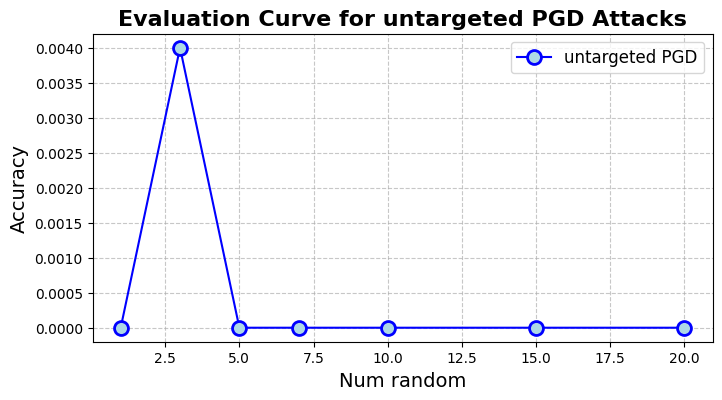

In [ ]:
accuracy_NPGDNRI = np.load("AccuracyNN1\\nn1_accuracy_NPGDNRI.npy")

plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the untargeted PGD attack
plt.plot(num_random_init, accuracy_NPGDNRI, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="untargeted PGD")

# Visualization settings
plt.xlabel('Num random', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for untargeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Num_Random_Init

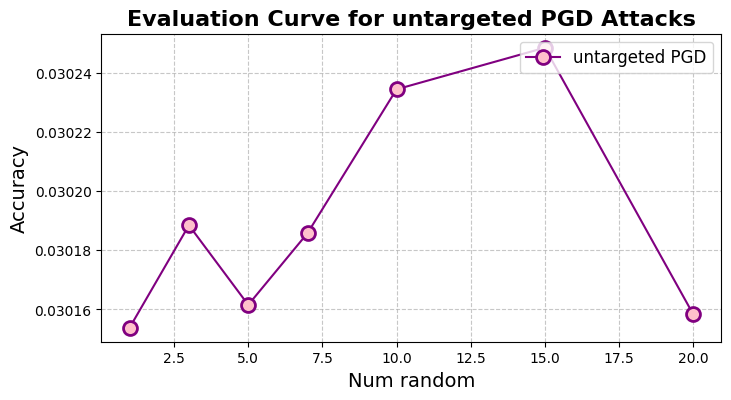

In [ ]:
perturbation_NPGDNRI = np.load("Perturbation\\perturbation_NPGDNRI.npy")

plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the untargeted PGD attack
plt.plot(num_random_init, perturbation_NPGDNRI, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="untargeted PGD")

# Visualization settings
plt.xlabel('Num random', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for untargeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## TARGETED PGD


Generate attack

### Epsilon

In [ ]:
epsilon_list = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

# Preporocessing
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

# PGD parameters
epsilon_step = 0.05
max_iter = 15
num_random_init = 5

#Target parameters
target_class = np.where(LABELS == ' Brad_Pitt')[0]
targeted_labels = target_class*np.ones(1)
one_hot_targeted_labels = tf.one_hot(targeted_labels, LABELS.size)

for epsilon in epsilon_list:
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, max_iter=max_iter, eps_step=epsilon_step, targeted=True)

    for p in os.listdir(path):
        dir = os.path.join(path, p)

        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "TPGD", "Epsilon", "Epsilon_" + str(epsilon), p)
        os.makedirs(save_dir, exist_ok=True)

        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            img = load_image(image_path)

            # Generate the adversarial samples
            adv = attack.generate(img.unsqueeze(0).numpy(), one_hot_targeted_labels.numpy())

            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\TPGD\\Epsilon\\Epsilon_" + str(epsilon) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_TPGDEp, perturbation_TPGDEp = evaluate_targeted_attack("adv\\TPGD\\Epsilon", 'Brad_Pitt')

Value:  0.0025  Accuracy:  0.0 % Perturbation:  0.01
Value:  0.005  Accuracy:  0.5 % Perturbation:  0.01
Value:  0.01  Accuracy:  4.0 % Perturbation:  0.01
Value:  0.05  Accuracy:  74.0 % Perturbation:  0.03
Value:  0.1  Accuracy:  99.5 % Perturbation:  0.05
Value:  0.2  Accuracy:  100.0 % Perturbation:  0.09
Value:  0.3  Accuracy:  100.0 % Perturbation:  0.11
Value:  0.5  Accuracy:  100.0 % Perturbation:  0.12
Value:  0.75  Accuracy:  100.0 % Perturbation:  0.12
Value:  1  Accuracy:  100.0 % Perturbation:  0.12


In [ ]:
accuracy_array = np.array(accuracy_TPGDEp)
perturbation_array = np.array(perturbation_TPGDEp)

np.save("AccuracyNN1\\nn1_accuracy_TPGDEp.npy", accuracy_array)
np.save("Perturbation\\perturbation_TPGDEp.npy", perturbation_array)

#### Security Evaluation Curve for Targeted PGD Attacks

Accuracy vs Epsilon

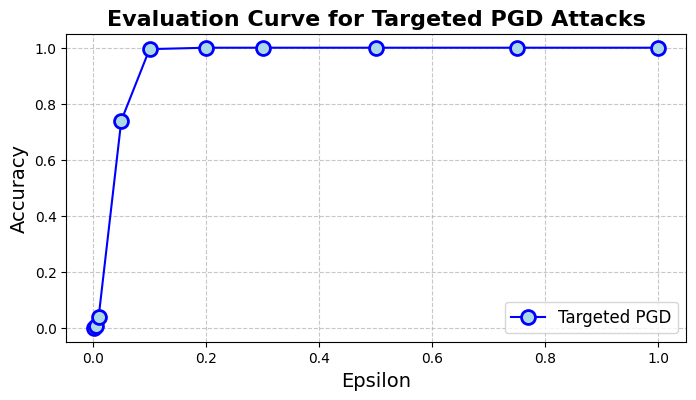

In [ ]:
accuracy_TPGDEp = np.load("Accuracy\\nn1_accuracy_TPGDEp.npy")

plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted PGD attack
plt.plot(epsilon_list, accuracy_TPGDEp, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Targeted PGD")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Targeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Epsilon

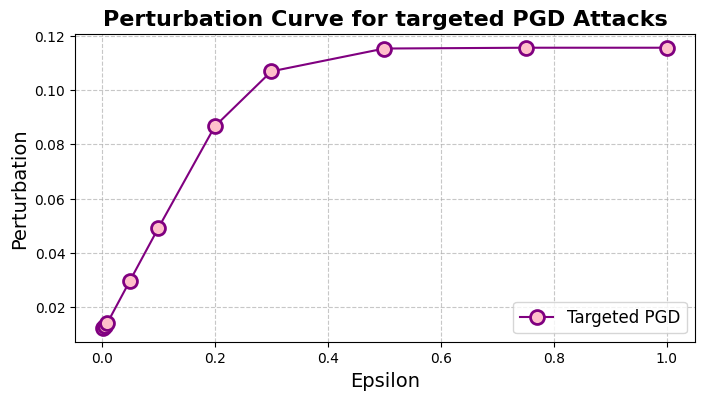

In [ ]:
perturbation_TPGDEp = np.load("Perturbation\\perturbation_TPGDEp.npy")

plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the targeted PGD attack
plt.plot(epsilon_list, perturbation_TPGDEp, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Targeted PGD")

# Visualization settings
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for targeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Epsilon Step

In [ ]:
epsilon_step_list = [0.0005, 0.004, 0.01, 0.02, 0.04]

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

# Preporocessing
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

# PGD parameters
epsilon = 0.1
max_iter = 15
num_random_init = 5

#Target parameters
target_class = np.where(LABELS == ' Brad_Pitt')[0]
targeted_labels = target_class*np.ones(1)
one_hot_targeted_labels = tf.one_hot(targeted_labels, LABELS.size)

for epsilon_step in epsilon_step_list:
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, max_iter=max_iter, eps_step=epsilon_step, targeted=True)
    iterazione = 0
    for p in os.listdir(path):
        dir = os.path.join(path, p)
        iterazione = iterazione + 1
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "TPGD", "Step", "Step_" + str(epsilon_step), p)
        os.makedirs(save_dir, exist_ok=True)
        if iterazione <20:
            for i in os.listdir(dir):
                image_path = os.path.join(dir, i)

                # Load the image
                img = load_image(image_path)


                # Generate the adversarial samples
                adv = attack.generate(img.unsqueeze(0).numpy(), one_hot_targeted_labels.numpy())

                # Save the adversarial sample
                adv = adv.squeeze(0).transpose(1, 2, 0)
                adv = np.clip(adv, 0, 1)
                adv = (adv * 255).astype(np.uint8)
                adv = Image.fromarray(adv)

                adv.save("adv\\TPGD\\Step\\Step_" + str(epsilon_step) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_TPGDStep, perturbation_TPGDStep = evaluate_targeted_attack("adv\\TPGD\\Step", 'Brad_Pitt')

Value  0.0005  Accuracy:  0.53 % Perturbation:  0.01
Value  0.004  Accuracy:  100.0 % Perturbation:  0.02
Value  0.01  Accuracy:  100.0 % Perturbation:  0.03
Value  0.02  Accuracy:  100.0 % Perturbation:  0.03
Value  0.04  Accuracy:  83.16 % Perturbation:  0.03


In [ ]:
accuracy_array = np.array(accuracy_TPGDStep)
perturbation_array = np.array(perturbation_TPGDStep)

np.save("AccuracyNN1\\nn1_accuracy_TPGDStep.npy", accuracy_array)
np.save("Perturbation\\perturbation_TPGDStep.npy", perturbation_array)

#### Security Evaluation Curve for Targeted PGD Attacks

Accuracy vs Epsilon_Step

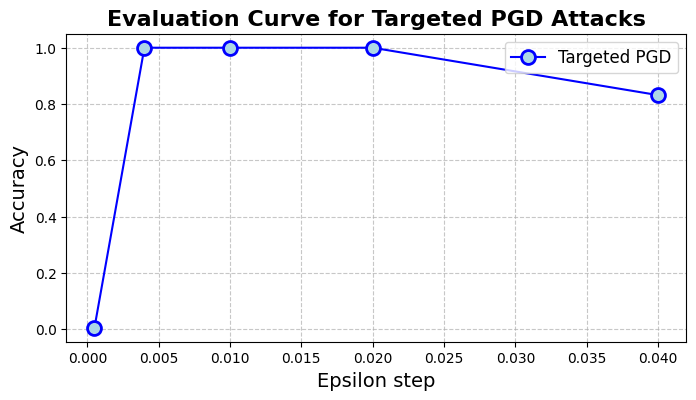

In [ ]:
accuracy_TPGDStep = np.load("AccuracyNN1\\nn1_accuracy_TPGDStep.npy")

plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted PGD attack
plt.plot(epsilon_step_list, accuracy_TPGDStep, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Targeted PGD")

# Visualization settings
plt.xlabel('Epsilon step', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Targeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Epsilon_Step

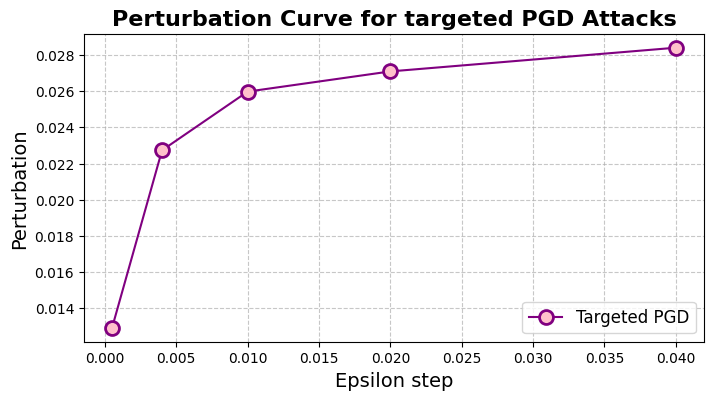

In [ ]:
perturbation_TPGDStep = np.load("Perturbation\\perturbation_TPGDStep.npy")
plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the targeted PGD attack
plt.plot(epsilon_step_list, perturbation_TPGDStep, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Targeted PGD")

# Visualization settings
plt.xlabel('Epsilon step', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for targeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Max Iter

In [ ]:
max_iter = [0, 1, 2, 5, 10, 15, 20, 50]

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

# Preporocessing
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

# PGD parameters
epsilon = 0.05
epsilon_step = 0.04
num_random_init = 15

#Target parameters
target_class = np.where(LABELS == ' Brad_Pitt')[0]
targeted_labels = target_class*np.ones(1)
one_hot_targeted_labels = tf.one_hot(targeted_labels, LABELS.size)

for iter in max_iter:
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=iter, num_random_init=num_random_init, targeted=True)
    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "TPGD","Iter", "Iter_" + str(iter), p)
        os.makedirs(save_dir, exist_ok=True)
        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            img = load_image(image_path)


            # Step 2: Generate the adversarial samples
            adv = attack.generate(img.unsqueeze(0).numpy(), one_hot_targeted_labels.numpy())

            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\TPGD\\Iter\\Iter_" + str(iter) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_TPGDMi, perturbation_TPGDMi = evaluate_targeted_attack("adv\\TPGD\\Iter", 'Brad_Pitt')

Value  0  Accuracy:  0.0 % Perturbation:  0.01
Value  1  Accuracy:  43.0 % Perturbation:  0.03
Value  2  Accuracy:  72.5 % Perturbation:  0.03
Value  5  Accuracy:  75.32 % Perturbation:  0.03
Value  10  Accuracy:  77.0 % Perturbation:  0.03
Value  15  Accuracy:  93.54 % Perturbation:  0.03
Value  20  Accuracy:  100.0 % Perturbation:  0.03
Value  50  Accuracy:  100.0 % Perturbation:  0.03


In [ ]:
accuracy_array = np.array(accuracy_TPGDMi)
perturbation_array = np.array(perturbation_TPGDMi)

np.save("Accuracy\\nn1_accuracy_TPGDMi.npy", accuracy_array)
np.save("Perturbation\\perturbation_TPGDMi.npy", perturbation_array)

#### Security Evaluation Curve for Targeted PGD Attacks

Accuracy vs Max_Iter

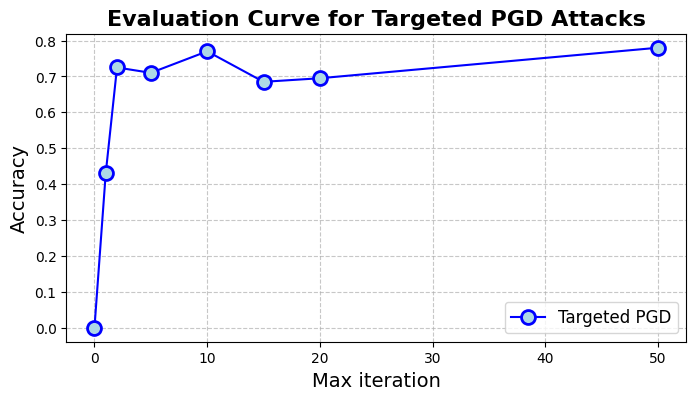

In [ ]:
accuracy_TPGDMi = np.load("AccuracyNN1\\nn1_accuracy_TPGDMi.npy")

plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted PGD attack
plt.plot(max_iter, accuracy_TPGDMi, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Targeted PGD")

# Visualization settings
plt.xlabel('Max iteration', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Targeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Max_Iter

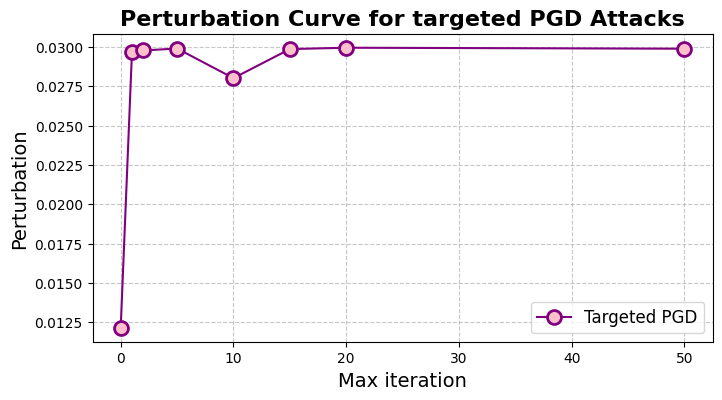

In [ ]:
perturbation_TPGDMi = np.load("Perturbation\\perturbation_TPGDMi.npy")

plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the targeted PGD attack
plt.plot(max_iter, perturbation_TPGDMi, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Targeted PGD")

# Visualization settings
plt.xlabel('Max iteration', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for targeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Num random init

In [ ]:
num_random_init_list = [1,3,5,7,10,15,20]

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

# Preporocessing
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

# PGD parameters
epsilon = 0.05
epsilon_step = 0.04
max_iter = 20

#Target parameters
target_class = np.where(LABELS == ' Brad_Pitt')[0]
targeted_labels = target_class*np.ones(1)
one_hot_targeted_labels = tf.one_hot(targeted_labels, LABELS.size)

for num_random_init in num_random_init_list:
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=iter, num_random_init=num_random_init, targeted=True)
    for p in os.listdir(path):
        dir = os.path.join(path, p)
        # Prepare the directory for saving the adversarial sample
        save_dir = os.path.join("adv", "TPGD","Num", "Num_random_init_" + str(iter), p)
        os.makedirs(save_dir, exist_ok=True)
        for i in os.listdir(dir):
            image_path = os.path.join(dir, i)

            # Load the image
            img = load_image(image_path)


            # Step 2: Generate the adversarial samples
            adv = attack.generate(img.unsqueeze(0).numpy(), one_hot_targeted_labels.numpy())

            # Save the adversarial sample
            adv = adv.squeeze(0).transpose(1, 2, 0)
            adv = np.clip(adv, 0, 1)
            adv = (adv * 255).astype(np.uint8)
            adv = Image.fromarray(adv)

            adv.save("adv\\TPGD\\Num\\Num_random_init_" + str(iter) + "\\" + p + "\\" + i)

Calculate accuracy and perturbation

In [ ]:
accuracy_TPGDNRI, perturbation_TPGDNRI = evaluate_targeted_attack("adv\\TPGD\\Num", 'Brad_Pitt')

Value  1  Accuracy:  76.5 % Perturbation:  0.03
Value  3  Accuracy:  71.5 % Perturbation:  0.03
Value  5  Accuracy:  100.0 % Perturbation:  0.03
Value  7  Accuracy:  93.99 % Perturbation:  0.03
Value  10  Accuracy:  97.42 % Perturbation:  0.03
Value  15  Accuracy:  98.72 % Perturbation:  0.03
Value  20  Accuracy:  93.87 % Perturbation:  0.03


In [ ]:
accuracy_array = np.array(accuracy_TPGDNRI)
perturbation_array = np.array(perturbation_TPGDNRI)

np.save("AccuracyNN1\\nn1_accuracy_TPGDNRI.npy", accuracy_array)
np.save("Perturbation\\perturbation_TPGDNRI.npy", perturbation_array)

#### Security Evaluation Curve for Targeted PGD Attack

Accuracy vs Num_Random_Init

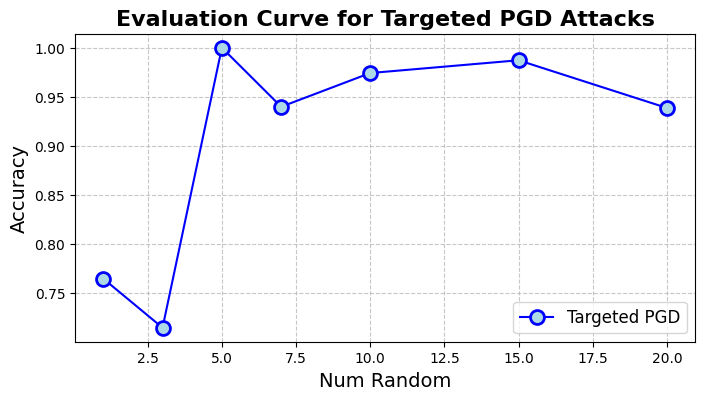

In [ ]:
accuracy_TPGDNRI = np.load("AccuracyNN1\\nn1_accuracy_TPGDNRI.npy")

plt.figure(figsize=(8, 4))

# Drawing the evaluation curve for the targeted PGD attack
plt.plot(num_random_init_list, accuracy_TPGDNRI, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='lightblue', markeredgecolor='blue', color='blue', label="Targeted PGD")

# Visualization settings
plt.xlabel('Num Random', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Evaluation Curve for Targeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Perturbation vs Num_Random_Init

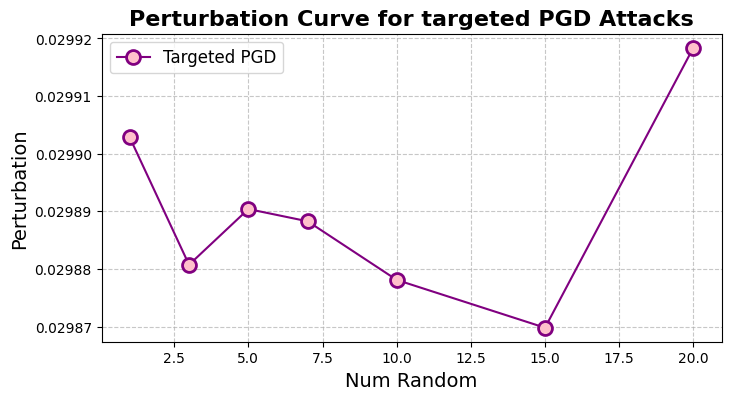

In [ ]:
perturbation_TPGDNRI = np.load("Perturbation\\perturbation_TPGDNRI.npy")

plt.figure(figsize=(8, 4))

# Drawing the perturbation curve for the targeted PGD attack
plt.plot(num_random_init_list, perturbation_TPGDNRI, marker='o', markersize=10, markeredgewidth=2, markerfacecolor='pink', markeredgecolor='purple', color='purple', label="Targeted PGD")

# Visualization settings
plt.xlabel('Num Random', fontsize=14)
plt.ylabel('Perturbation', fontsize=14)
plt.title('Perturbation Curve for targeted PGD Attacks', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()